# Analysis of dynamic network ABM
Standard networks, no SDA yet, social comparison included

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import itertools

/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_2799/2894705791.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from model_dynamicnetwork_newdata import ConsumatModel

In [3]:
base_config = {
    'TP_percentage': 0.6,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget'],
    'seed': 42  
}

watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.7
    }
})


barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.7
    }
})


## Network topology

### Watts-Strogatz Network
- **Type:** Small-world network
- **Known For:** High clustering coefficient and short average path lengths, which mimic many real-world social networks.
- **Formation:** Starts with a ring of `n` nodes each connected to `k` nearest neighbors. Rewires each edge with probability `p` to a randomly chosen node.
- **Key Parameters:**
  - `n`: Number of nodes
  - `k`: Number of nearest neighbors in the initial ring topology
  - `p`: Probability of rewiring each edge

### Barabasi-Albert Network
- **Type:** Scale-free network
- **Known For:** Its degree distribution follows a power law, which is typical for many large networks such as the internet, citation networks, and some social networks.
- **Formation:** Begins with a small number of nodes and adds new nodes one at a time. Each new node is connected to `k` existing nodes with a probability that depends on the number of links that the existing nodes already have.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges to attach from a new node to existing nodes

### Random Regular Network
- **Type:** Regular graph
- **Known For:** Every node has the same number of connections. This uniformity can represent idealized conditions in network modeling.
- **Formation:** Constructed by connecting each node with `d` neighbors chosen at random, ensuring each has the same degree, while avoiding self-loops and duplicate edges.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `d`: Degree of each node

### Holme-Kim Network
- **Type:** Small-world network with scale-free properties
- **Known For:** Combines high clustering and short path lengths (like Watts-Strogatz) with a degree distribution that follows a power law (like Barabasi-Albert).
- **Formation:** Starts like the Barabasi-Albert model by adding one node at a time, connecting to `m` existing nodes based on their degree. After each edge creation, with probability `p` adds an additional edge forming a triangle.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges each new node will attempt to make
  - `p`: Triad formation probability



# Functions that can accept various configurations:

In [4]:

def run_simulation(model, num_steps):
    adoption_rates = []

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    all_simulation_data = {}
    
    for config_name, config in configurations.items():
        print(f"Running simulations for {config_name} with parameters: {config}")
        
        all_simulation_data[config_name] = []
        
        for simulation in range(num_simulations):
            model = ConsumatModel(config)
            model_data, agent_data = run_simulation(model, num_steps)
            all_simulation_data[config_name].append(model_data)

        aggregated_data = pd.concat(all_simulation_data[config_name]).groupby(level=0).mean()
        results[config_name] = aggregated_data

    return results, all_simulation_data


def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count





In [13]:

def plot_adoption_rates(all_simulation_data, varying_params):
    param_name = list(varying_params.keys())[0]
    
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(12, 8))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], label=f'{param_name} - Simulation {idx + 1}', alpha=0.7)
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  



def plot_network_metrics(results, varying_params):
    param_name = list(varying_params.keys())[0]
    
    network_groups = {}
    for config_name in results.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 5))
        
        metrics_plotted = False
        for config_name in config_names:
            aggregated_data = results[config_name]
            tp_value = config_name.split('_TP_')[1]
            if 'Average Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Degree'], marker='o', label=f'Average Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Variance of Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Variance of Degree'], marker='o', label=f'Variance of Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Clustering' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Clustering'], marker='o', label=f'Average Clustering {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Path Length' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Path Length'], marker='o', label=f'Average Path Length {param_name} {tp_value}', linestyle='--')
                metrics_plotted = True
        
        if metrics_plotted:
            plt.xlabel('Step')
            plt.ylabel('Metric Value')
            plt.title(f'Network Metrics Over Time for {network_name}')
            plt.legend()
            plt.show()


def plot_decision_modes(network_configurations, num_steps):
    for network_name, config in network_configurations.items():
        model = ConsumatModel(config)
        _, agent_data = run_simulation(model, num_steps)
        
        decision_modes_count = generate_decision_modes_count(agent_data)
        print(f"Decision Mode Counts for {network_name} network:")
        print(decision_modes_count)

        plt.figure(figsize=(12, 8))
        plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label='Repeat', linestyle='-', marker='o')
        plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label='Imitate', linestyle='--', marker='x')
        plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label='Deliberate', linestyle='-.', marker='s')
        plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label='Social Compare', linestyle=':', marker='d')
        plt.title(f'Decision Modes over Time for {network_name} network')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

In [23]:
varying_params = {'TP_percentage': [0.6]}  
results, all_simulation_data = run_all_simulations(
    {'holme_kim': holme_kim_config},
    num_steps=6,  
    num_simulations=10 
)

Running simulations for holme_kim with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.7}}


Simulation Progress: 100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


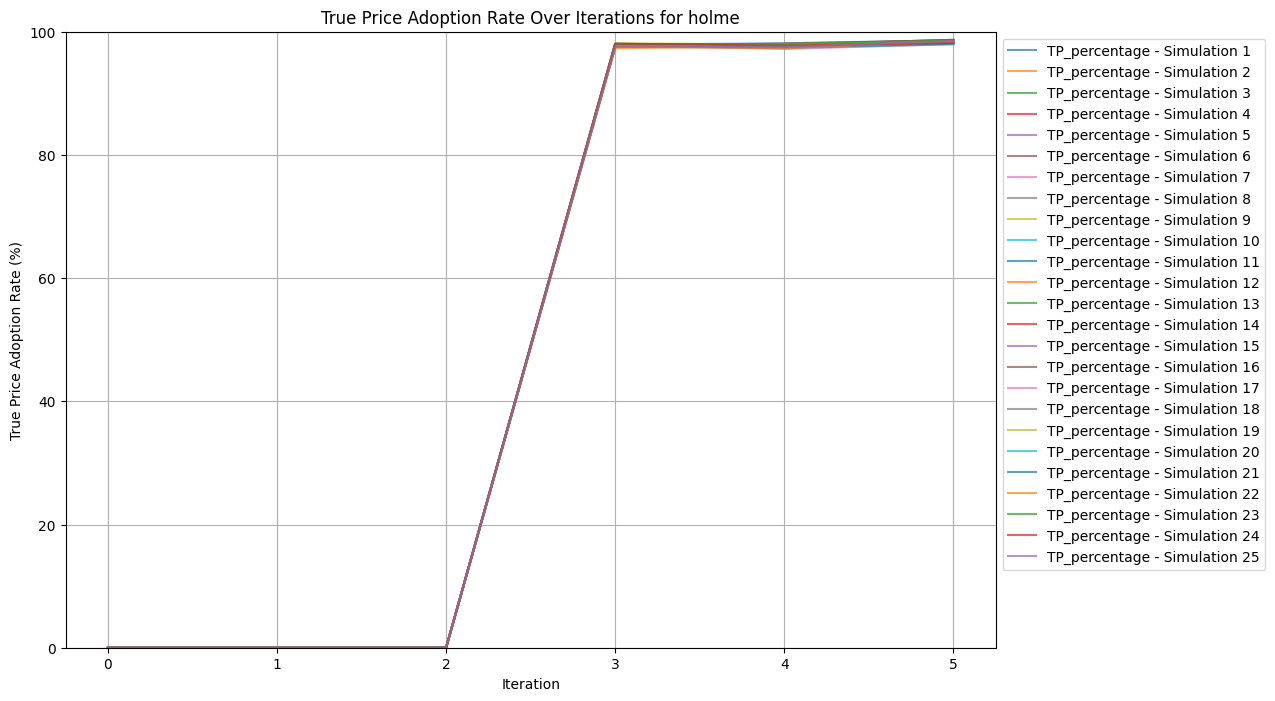

In [21]:
plot_adoption_rates(all_simulation_data, varying_params)


In [61]:

def generate_configurations(base_config, varying_params):
    keys, values = zip(*varying_params.items())
    configurations = []
    
    for combination in itertools.product(*values):
        config = base_config.copy()
        config.update(dict(zip(keys, combination)))
        configurations.append(config)
    
    return configurations


### Vary TP percentage

Running simulations for Watts-Strogatz_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Running simulations for Watts-Strogatz_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


Running simulations for Watts-Strogatz_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


Running simulations for Watts-Strogatz_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


Running simulations for Barabasi-Albert_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Running simulations for Barabasi-Albert_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


Running simulations for Barabasi-Albert_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Running simulations for Barabasi-Albert_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


Running simulations for Random Regular_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:28<00:00,  2.90s/it]


Running simulations for Random Regular_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


Running simulations for Random Regular_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Running simulations for Random Regular_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


Running simulations for Holme-Kim_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Running simulations for Holme-Kim_Config_2_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


Running simulations for Holme-Kim_Config_3_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Running simulations for Holme-Kim_Config_4_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 0.3}}


Simulation Progress: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


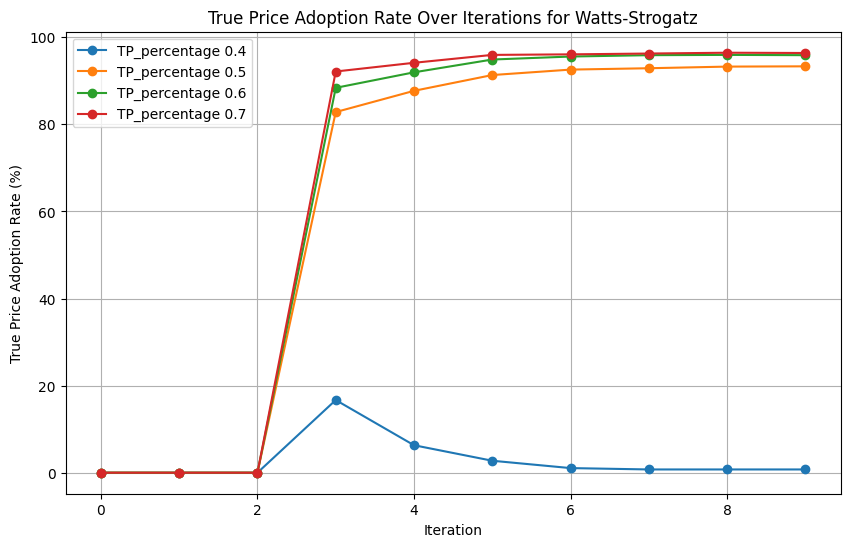

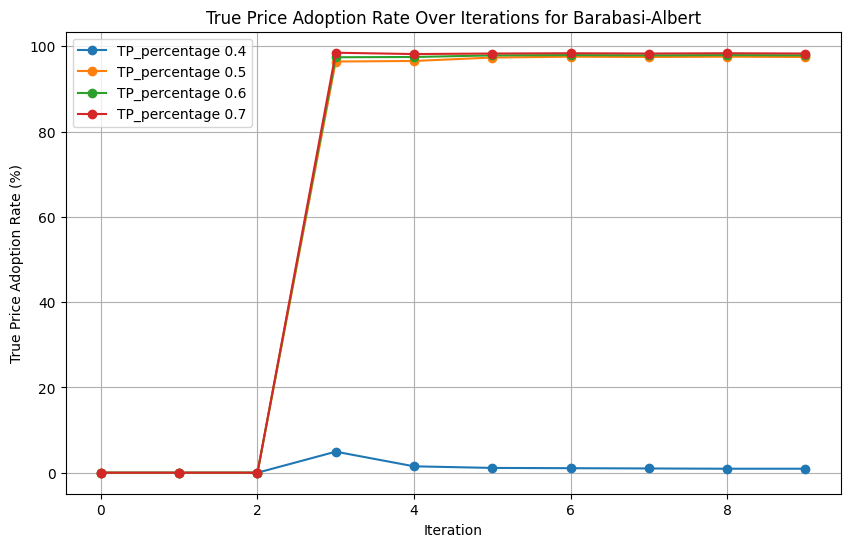

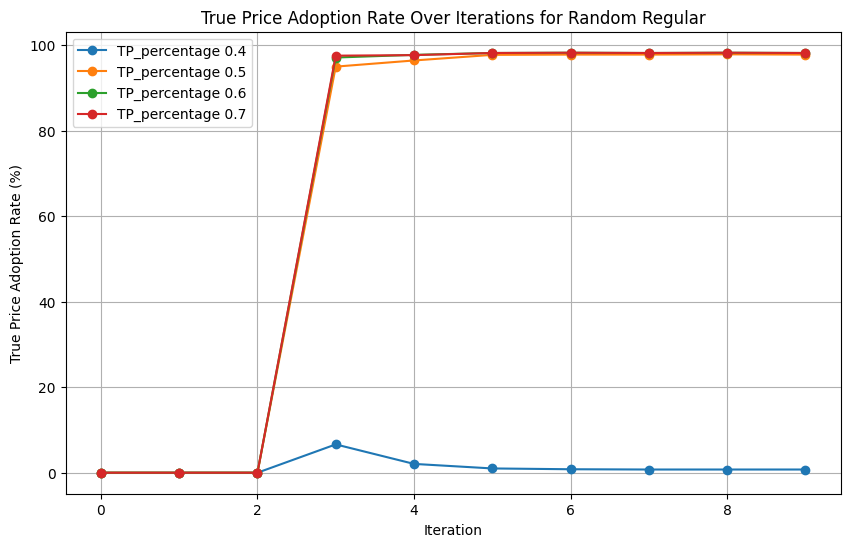

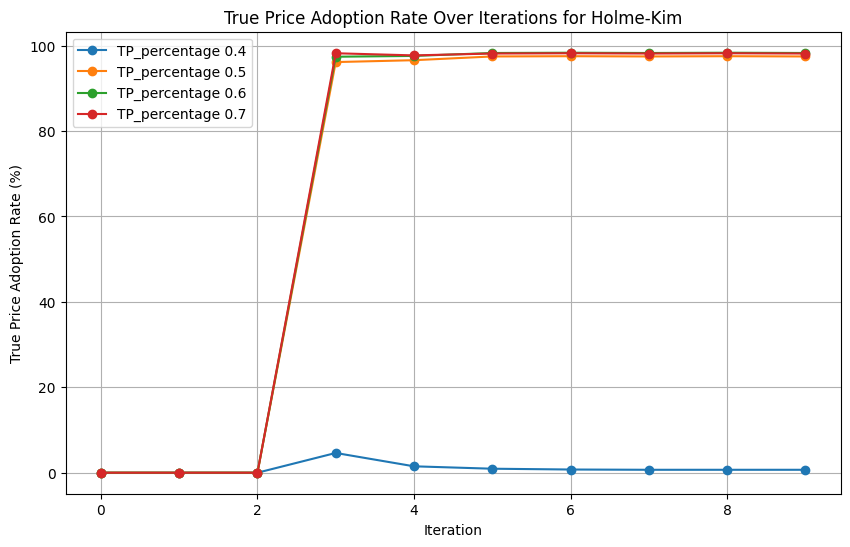

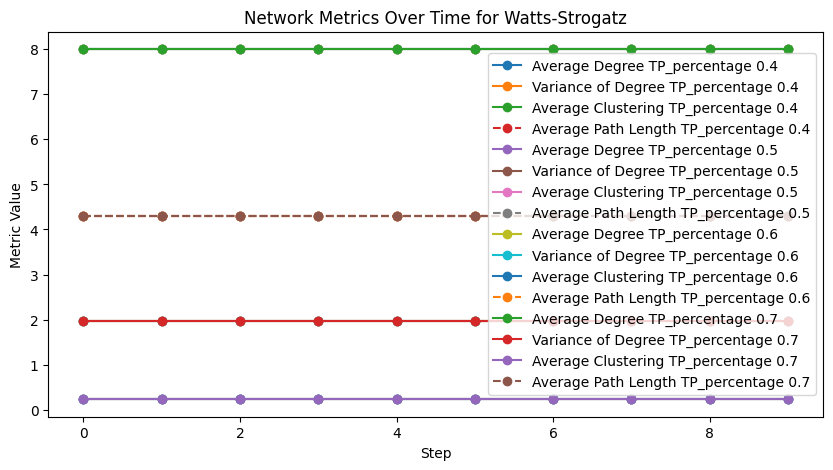

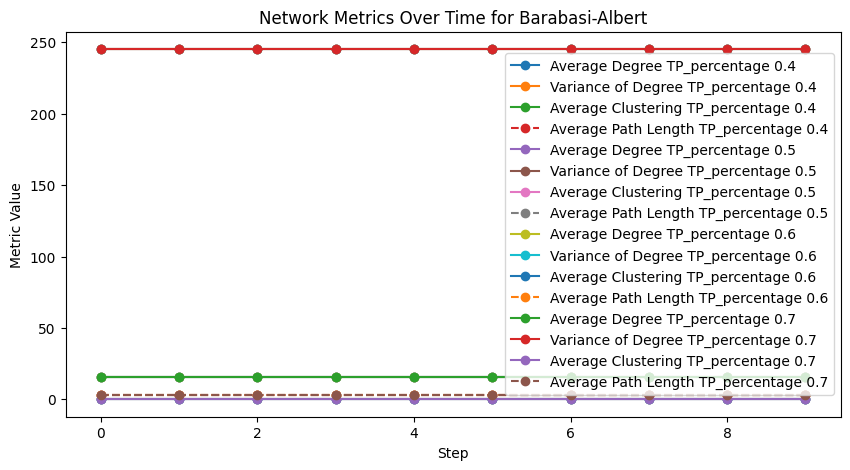

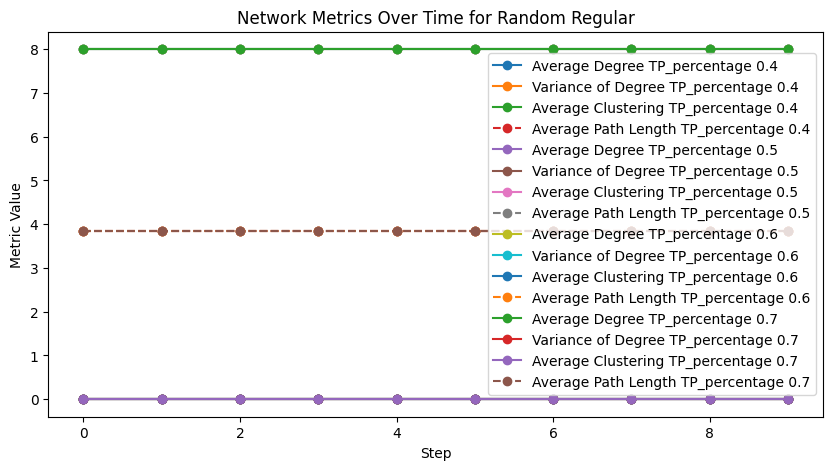

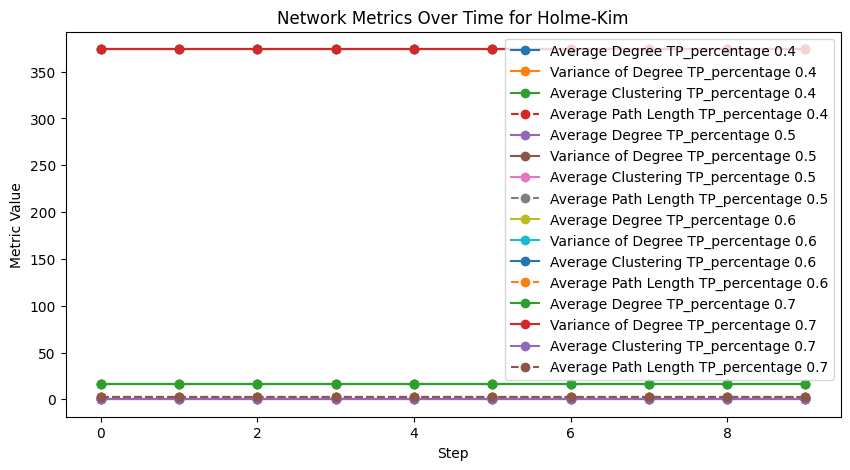

In [67]:
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

varying_params = {
    'TP_percentage': [0.4, 0.5, 0.6, 0.7],
}

num_simulations = 1
num_steps = 10

all_configurations = {}
for network_name, net_config in network_configurations.items():
    net_configs = generate_configurations({**base_config, **net_config}, varying_params)
    for idx, config in enumerate(net_configs):
        config_name = f"{network_name}_Config_{idx+1}_TP_{config['TP_percentage']}"
        all_configurations[config_name] = config

results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

plot_adoption_rates(all_simulation_data, varying_params)



### Vary 'p' parameter of Watts-Strogatz and Holme-Kim

Running simulations for Watts-Strogatz_p_0.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Running simulations for Watts-Strogatz_p_0.10 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Running simulations for Watts-Strogatz_p_0.20 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Running simulations for Watts-Strogatz_p_0.30 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Running simulations for Watts-Strogatz_p_0.40 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Running simulations for Watts-Strogatz_p_0.50 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Running simulations for Watts-Strogatz_p_0.60 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Running simulations for Watts-Strogatz_p_0.70 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Running simulations for Watts-Strogatz_p_0.80 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Running simulations for Watts-Strogatz_p_0.90 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Running simulations for Watts-Strogatz_p_1.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Running simulations for Holme-Kim_p_0.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


Running simulations for Holme-Kim_p_0.10 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


Running simulations for Holme-Kim_p_0.20 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


Running simulations for Holme-Kim_p_0.30 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


Running simulations for Holme-Kim_p_0.40 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


Running simulations for Holme-Kim_p_0.50 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


Running simulations for Holme-Kim_p_0.60 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


Running simulations for Holme-Kim_p_0.70 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


Running simulations for Holme-Kim_p_0.80 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


Running simulations for Holme-Kim_p_0.90 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


Running simulations for Holme-Kim_p_1.00 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'p': 1.0}}


Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


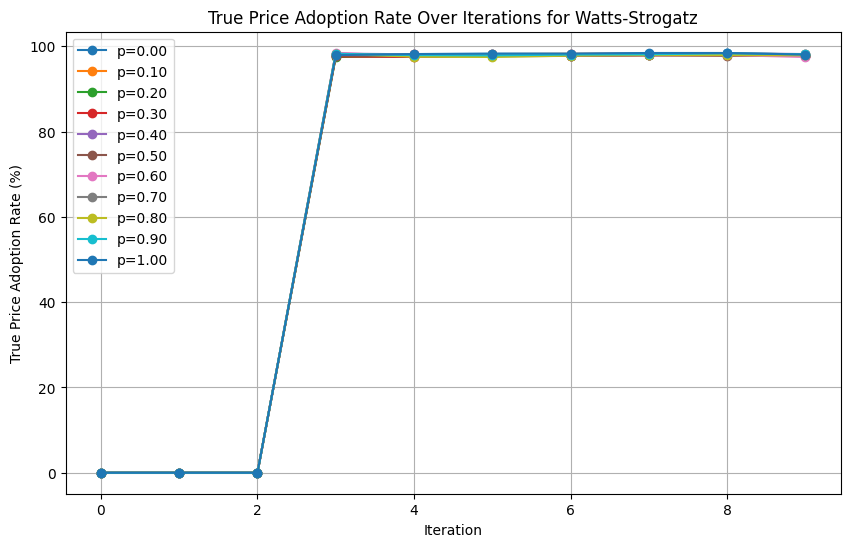

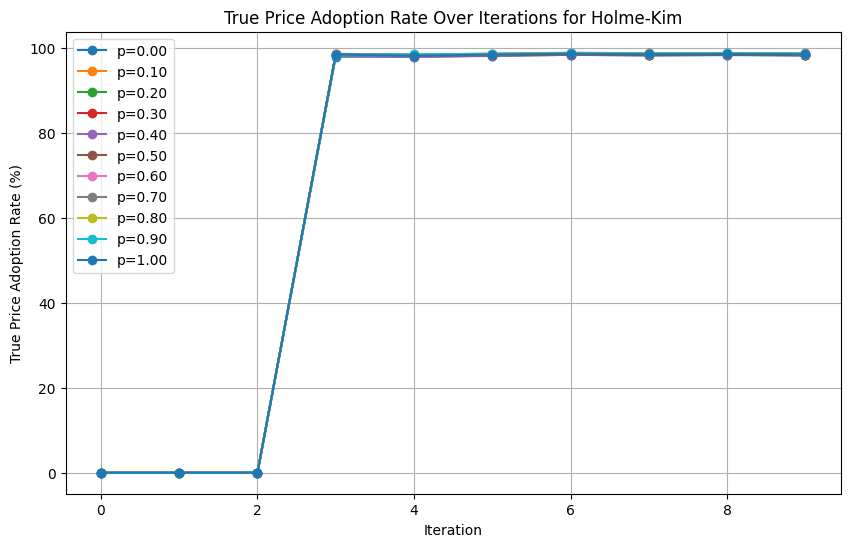

In [73]:
parameter_name = 'p'
parameter_values = np.linspace(0, 1, 10)
num_steps = 10
num_simulations = 1

base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42  
}

network_configurations = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 8,
            'p': 0.3
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 8,
            'p': 0.3
        }
    }
}

parameter_name = 'p'
parameter_values = np.arange(0, 1.1, 0.10)
num_steps = 10
num_simulations = 1

def generate_varying_param_configurations(base_config, network_configurations, parameter_name, parameter_values):
    all_configurations = {}
    for network_name, net_config in network_configurations.items():
        for value in parameter_values:
            config = base_config.copy()
            config.update(net_config)
            config['network_params'][parameter_name] = value
            config_name = f"{network_name}_p_{value:.2f}"
            all_configurations[config_name] = config
    return all_configurations

all_configurations = generate_varying_param_configurations(base_config, network_configurations, parameter_name, parameter_values)

results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

def plot_varying_parameter_results(all_simulation_data, parameter_name):
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_p_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 6))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            p_value = config_name.split('_p_')[1]
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], marker='o', label=f'p={p_value}')
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

plot_varying_parameter_results(all_simulation_data, parameter_name)


# Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

In [82]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42  
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

network_problems = {
    'Watts-Strogatz': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage','max_increase_percentage', 'k', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1]] 
    },
    'Barabasi-Albert': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon','min_increase_percentage', 'max_increase_percentage', 'm'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Random Regular': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','d'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10]]  
    },
    'Holme-Kim': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','m', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20],[2, 10], [0, 1]] 
    }
}

In [83]:
num_samples = 256

samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_34314/2869512302.py:7: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


In [84]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import json

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['epsilon'] = params[3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S2': Si['S2'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    with open(f'sensitivity_results_{network_name}.json', 'w') as f:
        json.dump(results, f)


Running GSA for Watts-Strogatz network...


Running simulations for Watts-Strogatz: 100%|██████████| 36/36 [01:58<00:00,  3.30s/it]


                               ST   ST_conf
TP_percentage            0.004382  1.176029
satisfaction_threshold   0.000024  0.006787
uncertainty_threshold    0.000000  0.000000
epsilon                  0.000000  0.000000
min_increase_percentage  0.000320  0.099818
max_increase_percentage  0.000005  0.001698
k                        0.000000  0.000000
p                        0.001570  0.008280
                               S1    S1_conf
TP_percentage            0.050348  18.806320
satisfaction_threshold   0.003954   1.427986
uncertainty_threshold    0.000000   0.000000
epsilon                  0.000000   0.000000
min_increase_percentage  0.017783   5.467079
max_increase_percentage -0.002280   0.713201
k                        0.000000   0.000000
p                       -0.016207   0.210056
                                                          S2    S2_conf
(TP_percentage, satisfaction_threshold)             0.650799  32.147862
(TP_percentage, uncertainty_threshold)              0.6

Running simulations for Barabasi-Albert:   0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 